# Grad-CAM class activation visualization

https://keras.io/examples/vision/grad_cam/#configurable-parameters

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2023-05-05 01:54:54.773579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BASE = '/Users/brinkley97/Documents/development/'
CLASS_PATH = 'classes/csci_535_multimodal_probabilistic_learning/'
DATASET_PATH = 'datasets/'

In [3]:
# model_builder = keras.applications.xception.Xception(weights='imagenet',include_top=True)
# img_size = (299, 299)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_p"redictions
# print(model_builder.summary())

In [4]:
# last_conv_layer_name = "block14_sepconv2_act"

In [21]:
from keras.applications.vgg19 import VGG19
model_builder = keras.applications.vgg19
img_size = (299, 299)
preprocess_input = keras.applications.vgg19.preprocess_input
decode_predictions = keras.applications.vgg19.decode_predictions
model_builder = VGG19(weights="imagenet", include_top=True)
# print(model_builder.summary())

In [22]:
last_conv_layer_name = "block5_conv4"

In [23]:
# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#     # "101_DFA.jpg", "https://drive.google.com/drive/u/0/folders/1KNs_M9X8j3IiQ9R3TBFr31QiCgy5Mm5L"
# )

# display(Image(img_path))

In [24]:
# img_path = BASE + CLASS_PATH + DATASET_PATH + 'misc/mug.jpg'
# display(Image(img_path))

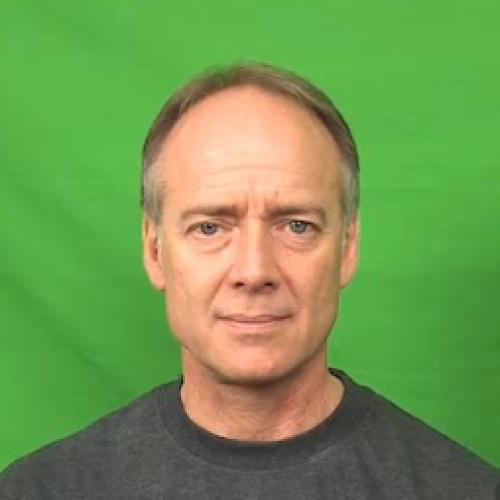

In [25]:
img_path = BASE + CLASS_PATH + DATASET_PATH + 'project/crema_d/faces_to_specific_emotion_folder_crema_d/dis_crema_d/1001_DFA_DIS_XX_frame1.jpg'
display(Image(img_path))

In [26]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    # img = keras.preprocessing.image.load_img(img_path, target_size=size)
    
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1
1/1 [==============================] - 0s 251ms/step
Predicted: [('n04039381', 'racket', 7.3694067)]


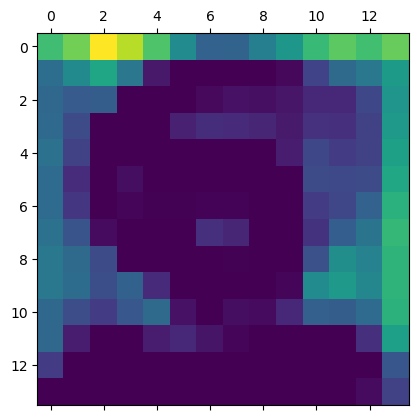

In [28]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

print(len(img_array))
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

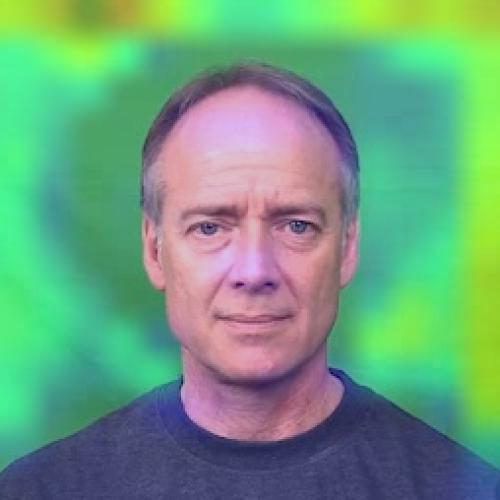

In [28]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)